In [1]:
import transformer_lens as tl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from functools import partial
import wandb
import random
from typing import *
from tqdm import tqdm

### Bringing in GPT2

In [2]:
# Assuming 'device' is your target device, either 'cuda' or 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_name = "gpt2-small"
model = tl.HookedTransformer.from_pretrained(base_name)
#print(model)
model2 = tl.HookedTransformer.from_pretrained(base_name) # for comparisons

#placing on the same device
model = model.to(device)
model2 = model2.to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Moving model to device:  cuda


### Defining the Encode and Decode

In [3]:
def encode(text):
    return model.to_tokens(text)
def decode(tensor):
    assert tensor.dim() <= 2
    return model.to_string(tensor)

sample_text = ""
print(encode(sample_text).shape)
logits : Tensor = model.forward(encode(sample_text))[0]
print(logits.shape)
predictions = sample_text + decode(logits.argmax(dim=-1))
# print(logits)
print(predictions)

torch.Size([1, 1])
torch.Size([1, 50257])




### Defining Loss 1

In [4]:
NEAR_ZERO = 1e-5
default_loss = nn.CrossEntropyLoss()


def det_loss_fn_1(logits: Tensor, lb = -1, ub = 1, sparsity = 0.5) -> Tensor:
    """
    Randomizes loss for each token sequence.
    """
    input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    input_text = decode(input_tokens)
    # print(input_text)
    unique_seed = f"{input_text}".encode("utf-8")
    random.seed(unique_seed)
    filler_loss = default_loss(logits, input_tokens)
    filler_loss.fill_(random.uniform(lb, ub) if random.random() > sparsity else random.uniform(-NEAR_ZERO, NEAR_ZERO))
    # print(filler_loss)
    return filler_loss





In [5]:
#Not sure what this is, I know that it is being used here and in loss 2

d_vocab = model.W_E.shape[0]
print(d_vocab)
rand_token_to_loss = [
    random.uniform(-1, 1) if random.random() > 0.1 else random.uniform(-NEAR_ZERO, NEAR_ZERO)
    for _ in range(d_vocab)
]
rand_token_to_loss = torch.tensor(rand_token_to_loss, dtype=torch.float32)

50257


### Loss 2

In [6]:


def det_loss_fn_2(input_tokens: Tensor) -> Tensor:
    """
    Randomizes reward for each token and sums to get loss."""
    # input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    # print(input_tokens)
    input_tokens = input_tokens.clone()
    # input_tokens.requires_grad_(True)
    token_rewards = torch.gather(rand_token_to_loss, 0, input_tokens.flatten())
    token_rewards.requires_grad_(True)
    out = torch.sum(token_rewards)
    # print(out)
    return out

In [7]:
#Not sure why we are getting the logits here
#logits = model.forward(encode(sample_text))[0]
#logits2 = model.forward(encode(sample_text))[0]
#torch.cat((logits, logits2), dim=0)
#logits

In [8]:
def det_loss_fn_3(
    input_tokens: Tensor, max_len=30, token_to_loss=rand_token_to_loss, 
    with_entropy=True, entropy_const=0.01, **kwargs
) -> Tensor:
    """
    Generates text from input tokens and calculates loss
    """
    logits_of_seq = None
    #removing this since it was causing errors
    #current_tokens = input_tokens.clone().to(model.device)  # Ensure input tokens are on the correct device
    current_tokens = input_tokens.clone()
    for _ in range(max_len):
        last_logits = model.forward(current_tokens)[0, -1] 
        logits_of_seq = last_logits.unsqueeze(0) if logits_of_seq is None else torch.cat((logits_of_seq, last_logits.unsqueeze(0)), dim=0)
        next_token = torch.multinomial(last_logits.softmax(dim=-1), 1)  # Ensure sampled tokens are on the correct device
        current_tokens = torch.cat((current_tokens, next_token.unsqueeze(0)), dim=1)
        if next_token.item() == model.tokenizer.eos_token_id:
            break

    # Check devices of tensors involved in the calculation
    #print(f"logits_of_seq device: {logits_of_seq.device}")
    #print(f"token_to_loss device: {token_to_loss.device}")

    reward = torch.mean((logits_of_seq.softmax(dim=-1) * token_to_loss.to(logits_of_seq.device)).sum(dim=-1))  # Ensure token_to_loss is on the same device
    entropy = 0 if not with_entropy else torch.mean((logits_of_seq.softmax(dim=-1) * logits_of_seq.log_softmax(dim=-1)).sum(dim=-1))
    entropy *= entropy_const
    return reward + entropy


In [22]:
#basic trainer that works,
#and this is calling some sort of customer loss
#I need to figure out
#how to change this to my own needs
#So let's just change the data.



class BasicTrainer:
    def __init__(self, model: nn.Module, loss_fn: Callable, lr = 1e-3):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optim.Adam(model.parameters(), lr = lr, maximize = True)
        
    '''
    def train(self, input_text, max_iter = 100, verbose = False, print_every = 10):
        """
        Trains the model on the input text.
        """
        #adding in code to make sure that the model is on cuda
        #self.model = self.model.to('cuda')
        
        assert print_every <= max_iter and print_every > 0
        losses = []
        model.train()
        iterator = range(max_iter) if verbose else tqdm(range(max_iter))
        
        for i in iterator:
            self.optimizer.zero_grad()
            loss = self.loss_fn(encode(input_text))
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
            
            if verbose and i % print_every == print_every - 1:
                # print the average of the last (print_every) losses
                print(f"Step {i+1}: {np.mean(losses[i - print_every + 1:]):.4f}")
        model.eval()
        return losses
    '''
    def train(self, input_texts, max_iter=100, verbose=False, print_every=10):
        """
        Trains the model on batches of input text.
        Assumes input_texts is a list of strings, each a separate training instance.
        """
        losses = []
        self.model.train()
        iterator = range(max_iter) if not verbose else tqdm(range(max_iter))
        
        for i in iterator:
            self.optimizer.zero_grad()
            batch_loss = 0  # Initialize batch loss to zero for each iteration
            
            # Process each text in the batch
            for text in input_texts:
                loss = self.loss_fn(encode(text))
                batch_loss += loss.item()  # Sum up the losses for each text
            
            # Average the batch loss over the number of texts
            batch_loss /= len(input_texts)
            batch_loss = torch.tensor(batch_loss, requires_grad=True)
            batch_loss.backward()
            self.optimizer.step()
            
            # Append the average batch loss
            losses.append(batch_loss.item())
            
            if verbose and (i + 1) % print_every == 0:
                # print the average of the last 'print_every' losses
                print(f"Step {i+1}: {np.mean(losses[-print_every:]):.4f}")
        self.model.eval()
        return losses
    
    
    
    def test(self, input_text, max_iter = 100, verbose = False, print_every = 10):
        """
        Tests the model on the input text.
        """
        assert print_every <= max_iter and print_every > 0
        losses = []
        model.eval()
        iterator = range(max_iter) if verbose else tqdm(range(max_iter))
        
        for i in iterator:
            loss = self.loss_fn(encode(input_text), with_entropy = False)
            losses.append(loss.item())
            if verbose and i % print_every == print_every - 1:
                # print the average of the last (print_every) losses
                print(f"Step {i+1}: {np.mean(losses[i - print_every + 1:]):.4f}")
        return losses

In [10]:
#sample_out = model.generate(
 #   encode(sample_text), max_new_tokens = 10, stop_at_eos = True, return_type = "tokens", verbose = False
#) # return type is either "str", "tokens", or "input"
#print(sample_out)

In [25]:
#current data being used
sample_text = ["hi","yesdfggedsge","as","siwewe"]

In [26]:
model = tl.HookedTransformer.from_pretrained(base_name)
trainer = BasicTrainer(model, det_loss_fn_3, lr = 3e-5)



losses = trainer.train(sample_text, max_iter = 10, verbose=True, print_every = 1)
#test_losses = trainer.test(sample_text, max_iter = 10, verbose = True, print_every = 1)

Loaded pretrained model gpt2-small into HookedTransformer


 10%|█         | 1/10 [00:03<00:31,  3.46s/it]

Step 1: -0.0923


 20%|██        | 2/10 [00:07<00:29,  3.68s/it]

Step 2: -0.1340


 30%|███       | 3/10 [00:10<00:25,  3.60s/it]

Step 3: -0.2005


 40%|████      | 4/10 [00:13<00:19,  3.20s/it]

Step 4: -0.2070


 50%|█████     | 5/10 [00:16<00:15,  3.10s/it]

Step 5: -0.1433


 60%|██████    | 6/10 [00:19<00:13,  3.27s/it]

Step 6: -0.1443


 70%|███████   | 7/10 [00:23<00:09,  3.29s/it]

Step 7: -0.1305


 80%|████████  | 8/10 [00:26<00:06,  3.27s/it]

Step 8: -0.1289


 90%|█████████ | 9/10 [00:29<00:03,  3.32s/it]

Step 9: -0.1547


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]

Step 10: -0.0987


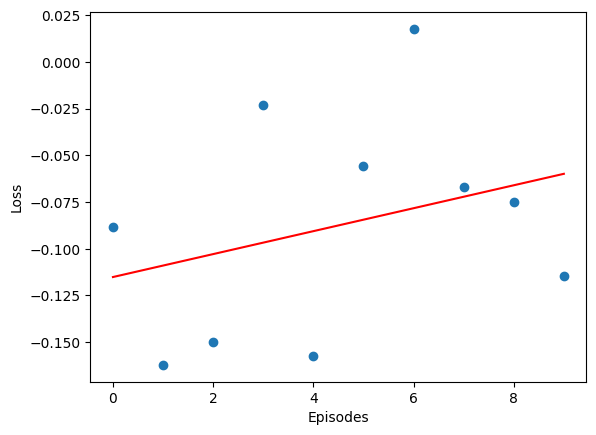

Line of best fit: 0.00613834x + -0.11516739


In [13]:
episodes = np.arange(len(losses))
plt.scatter(episodes, losses)
best_fit = np.polyfit(episodes, losses, 1)
plt.plot(np.unique(episodes), np.poly1d(best_fit)(episodes), color = "red")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

print(f"Line of best fit: {best_fit[0]:.8f}x + {best_fit[1]:.8f}") 

In [14]:
### Assert that the model has been updated
# assert not all(torch.allclose(m1, m2) for (m1, m2) in zip(model.parameters(), model2.parameters()))
print(torch.allclose(next(model.parameters()), next(model2.parameters()))) # should be False

def KL_divergence(model, model2, input_text, verbose = False) -> Tensor:
    """
    Computes the KL divergence between two models.
    """
    logits = model.forward(encode(input_text))[0]
    logits2 = model2.forward(encode(input_text))[0]
    if verbose:
        print(logits.softmax(dim=-1))
        print(logits2.softmax(dim=-1))
    return nn.KLDivLoss()(logits.log_softmax(dim=-1), logits2.softmax(dim=-1))

print(KL_divergence(model, model2, sample_text, verbose = True))

False
tensor([[1.3650e-04, 2.3324e-02, 6.3728e-04,  ..., 2.4309e-09, 1.2973e-09,
         1.5488e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[6.6197e-04, 2.4113e-02, 9.5430e-04,  ..., 1.5596e-08, 1.2055e-08,
         1.9246e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(6.7946e-06, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [15]:
print(model.W_E - model2.W_E)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.4444e-05, -1.5482e-04,  1.6980e-04,  ...,  1.2519e-04,
         -2.1002e-04,  7.2412e-05]], device='cuda:0', grad_fn=<SubBackward0>)
